<h1>HW2 - Convolutional Neural Networks- Practical Q1_Part A</h1>
<h3><font color=yellow>Total Points: 100</font></h3>



<font color=greeen>Please, name this file as HW2_Q1_{Student_ID}.ipynb</font>



```
# This is formatted as code
```

<h2>Full Name: Mohammad Navid Fazly</h2>
<h2>Student ID: 99100477</h2>

#Imports

In [1]:
import os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

#Preparing Data

In [2]:
%%capture


#defining the transforms we need (converting images to tensor and normalizing)
from torchvision import datasets, transforms

# Defining the transforms we need (converting images to tensor and normalizing)
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download FashionMNIST dataset
train_set = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
test_set = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)


In [3]:
# Import necessary library
from torch.utils.data import random_split

# Split training set into train and validation data
torch.manual_seed(0)

train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_ds, val_ds = random_split(train_set, [train_size, val_size])


In [4]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# Loading the dataset into memory using Dataloader
# use your desired batch size and shuffle is necessary

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
val_dataloader = DataLoader(train_set, batch_size=64, shuffle=True) # Assuming validation set is same as training set
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)

classes = train_set.classes




#Visualizing a few data samples

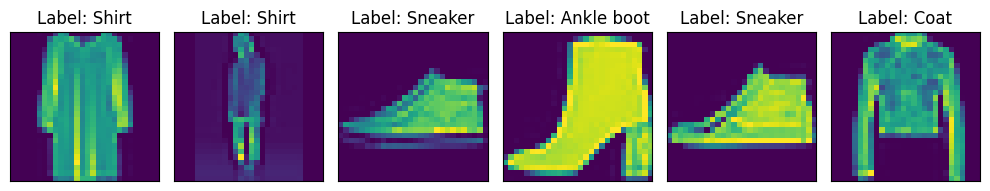

In [5]:
# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(10, 8), subplot_kw={'xticks': [], 'yticks': []})
for i,ax in zip(range(0,6),axes.flat):
    img,label=images[i],labels[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"Label: {classes[label]}")

plt.tight_layout()
plt.show()

#Building Model Arcitechture

<h2>Implement the Convolutional Neural Network shown below:</h2>

<img src='https://drive.google.com/uc?id=1eN-rEyMCmApg7tASsmtkBQM7HbU1ZORH'>

In [8]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

class Simple_CNN(nn.Module):
  def __init__(self):
    super(Simple_CNN, self).__init__()
    self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    self.layer2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, stride=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.fc1 = nn.Linear(2304, 600)
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(600, 120)
    self.fc3 = nn.Linear(120, 10)


  def forward(self, x):
    #################################################################################
    #                          COMPLETE THE FOLLOWING SECTION                       #
    #################################################################################
    """ Implement the forward propagation steps """
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

  def fit(self, num_epochs, train_loader, val_loader, optimizer, criterion):
    train_losses = []
    val_losses = []
    train_accuracies=[]
    val_accuracies=[]

    for epoch in range(num_epochs):
      train_per_epoch_loss=0
      train_data_total = 0
      train_data_correct = 0

      ####### Training Phase ########
      self.train()
      with tqdm(train_loader, unit="batch") as batches:
        epoch_loss = 0


        for images, labels in batches:
          images = images.to(device)
          labels = labels.to(device)
          batches.set_description(f"Epoch {epoch + 1}")
          """ Implement training steps """
          optimizer.zero_grad()
          outputs = self(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          _, predictions = torch.max(outputs.data, 1)
          train_data_correct += (predictions == labels).sum().item()
          train_data_total += labels.size(0)
          train_per_epoch_loss += loss.item()

          batches.set_postfix(train_loss = (train_per_epoch_loss/len(train_loader)), train_accuracy = (train_data_correct * 100 / train_data_total))

      train_accuracy = train_data_correct * 100 / train_data_total
      train_accuracies.append(train_accuracy)
      train_losses.append(train_per_epoch_loss/len(train_loader))


      val_per_epoch_loss=0
      val_data_total = 0
      val_data_correct = 0

      self.eval()
      with torch.no_grad():
           for images, labels in val_loader:
              images = images.to(device)
              labels = labels.to(device)
              """ Implement Validation steps """
              outputs = self(images)
              loss = criterion(outputs, labels)

              _, predictions = torch.max(outputs.data, 1)
              val_data_correct += (predictions == labels).sum().item()
              val_data_total += labels.size(0)
              val_per_epoch_loss += loss.item()

      val_accuracy = val_data_correct * 100 / val_data_total
      val_losses.append(val_per_epoch_loss/len(val_loader))



    self.history={
      'train_losses':train_losses,
      'val_losses':val_losses,
      'train_accuracies':train_accuracies,
      'val_accuracies':val_accuracies
    }
    return self.history


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Simple_CNN().to(device)



model.to(device)
print(model)


Simple_CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


#Training the model

In [10]:
num_epochs = 10
criterion = torch.nn.CrossEntropyLoss()  # Loss function
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

history = model.fit(num_epochs, train_dataloader, val_dataloader, optimizer, criterion)


Epoch 1: 100%|██████████| 938/938 [02:14<00:00,  6.95batch/s, train_accuracy=84.8, train_loss=0.431]


In [ ]:

plt.subplots(figsize=(7, 5))
sns.set_style("dark")
sns.lineplot(data=history['val_losses'],label="Validation Loss")
sns.lineplot(data=np.asarray(history['train_losses']),label="Train Loss").set(title="loss change during training", xlabel="epoch", ylabel="loss")
plt.legend()
plt.show()

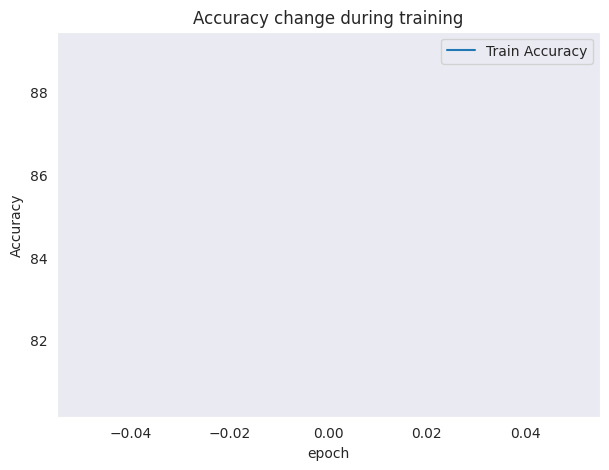

In [12]:
# plot Accuracy
plt.subplots(figsize=(7, 5))
sns.set_style("dark")
sns.lineplot(data=history['val_accuracies'],label="Validation Accuracy")
sns.lineplot(data=np.asarray(history['train_accuracies']),label="Train Accuracy").set(title="Accuracy change during training", xlabel="epoch", ylabel="Accuracy")
plt.legend()
plt.show()

# Prediction on Test Data

In [13]:
def predict(images, model):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)


    if isinstance(images, np.ndarray):
        images = torch.from_numpy(images).float()


    images = images.to(device)


    model.eval()


    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

    return predicted.cpu()



**Accuracy Result on Test Data**

In [14]:
correct = 0
total = 0
y_pred_list = []
y_true_list = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

with torch.no_grad():
  for data in test_dataloader:
    inputs, labels = data[0].to(device), data[1].to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    for x in predicted.cpu().numpy(): y_pred_list.append(x)
    for x in labels.cpu().numpy(): y_true_list.append(x)

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))


print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))


Accuracy of the network on the 10000 test images: 88 %
Accuracy of the network on the 10000 test images: 88 %


**Classification report**

In [ ]:
print(classification_report(y_true_list, y_pred_list, target_names=classes))

<Axes: >

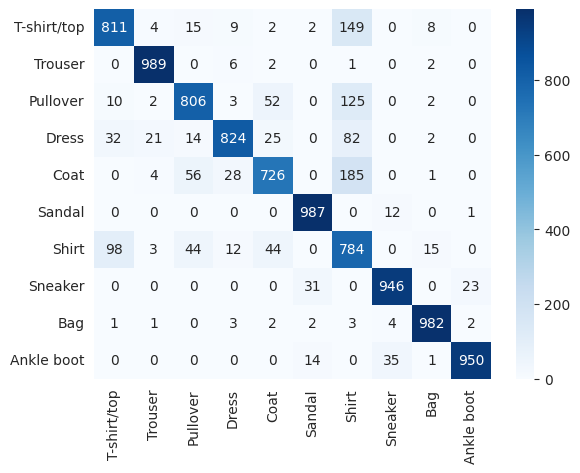

In [15]:
cf_matrix = confusion_matrix(y_true_list, y_pred_list)
sns.heatmap(cf_matrix, xticklabels=classes, yticklabels=classes, annot=True, cmap='Blues', fmt='g')

**Displaying a random set of images from test data**

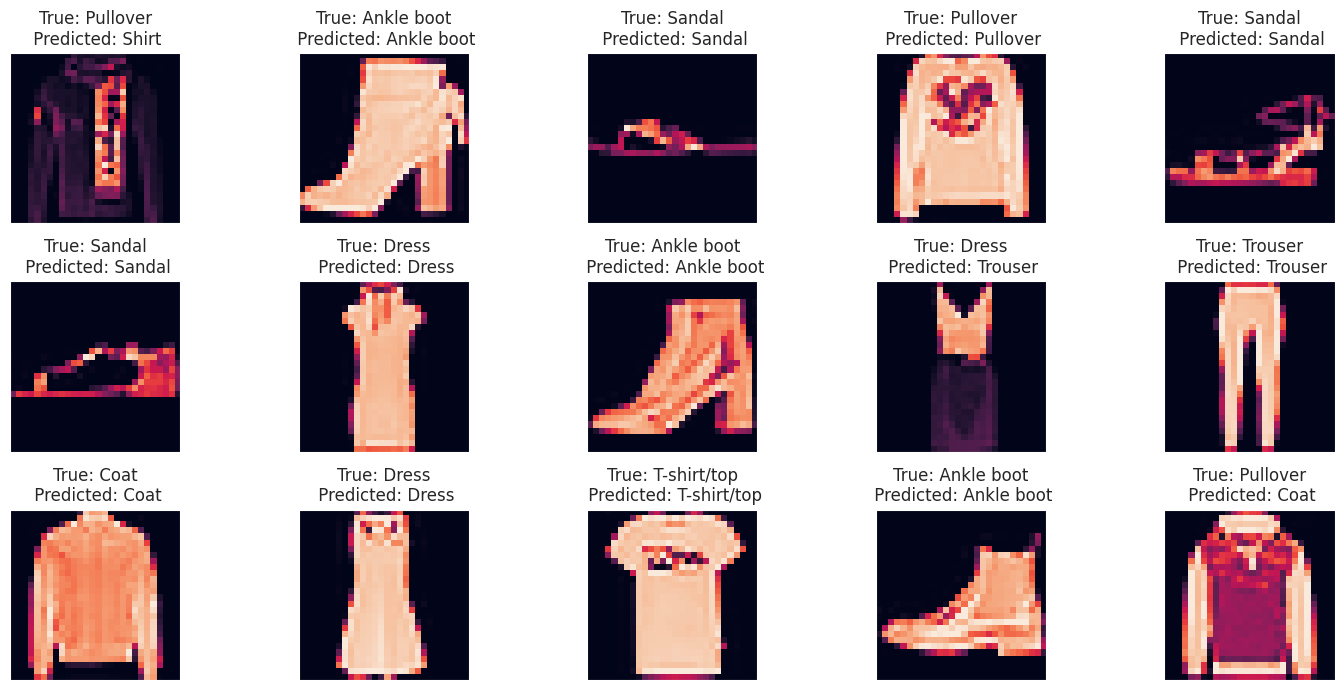

In [16]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
predicted=predict(images, model)

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})
for i,ax in zip(range(0,16),axes.flat):
    img,label=images[i],labels[i]
    pred=predicted[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"True: {classes[label]}\n Predicted: {classes[pred]}")

plt.tight_layout()
plt.show()